**CPLEX installation guide:** Add following line to your `.bash_profile` (for macOS) after installing IBM ILOG CPLEX Optimization Studio locally using installer from IBM. (note the path will change if you are using different python or OS)

```export PYTHONPATH="/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx"```

In [1]:
import cplex
print(cplex.__path__)  # make sure the path is the one we pick above

['/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx/cplex']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

## Parameters

In [3]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
path_init_conf =     '../output/m14-improved-v2.csv'
#path_init_conf =     '../input/another_pytorch_implementation.csv'
path_dump_improved = '../output/m14-improved-v2.csv' # output solution

num_cpu_cores = 6
time_limit = -1 # unlimited
time_limit = 2*60  # in s

occupancy_diff = 50  # +- the occupancy of input solution for each day
max_family_rank = 7  # maximum number of rank of the preference days for each family
use_hint = True      # use current input as hint
occupancy_count_as_variables = True  # use occupancy_counts as variable (seem faster)
min_choice_0_families = 100   # minimum number of families that are at their choice 0
target_pref_cost = 0 # 62868
target_pref_cost_error = 0
target_accounting_cost = 0 # 6020.043432
target_accounting_cost_error = 1000

In [4]:
families = range(N_families)
days = range(1, N_days + 1)

In [5]:
#print(list(days))

In [6]:
allowed_occupancy = range(N_min_people, N_max_people + 1)

In [7]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
try:
    is_valid = deep_check(assigned_day, family_on_day, occupancy)
except:
    is_valid = False
initial_score = cal_total(assigned_day, occupancy)
print('Valid solution: ', is_valid)
print('Total score:    ', initial_score)
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
deep check: everything looks fine.
Valid solution:  True
Total score:     70901.16843914894
Preference cost: 65596
Accounting cost: 5305.168439148937


In [8]:
print(occupancy, occupancy.shape)

[125 300 286 300 300 285 261 244 245 268 293 299 298 277 256 253 268 296
 284 271 244 222 229 258 282 298 289 269 254 240 247 266 270 249 218 189
 162 192 227 249 234 205 176 180 205 242 259 241 215 196 172 209 240 242
 221 185 153 125 225 252 235 201 162 125 125 125 244 214 176 131 125 125
 125 231 206 175 131 125 125 125 228 209 177 132 125 125 125 255 234 199
 161 125 125 125 232 206 173 126 125 125 125 125] (102,)


In [9]:
init_occupancy_counts = {o: 0 for o in allowed_occupancy}
for o in occupancy[1:-1]:
    init_occupancy_counts[o] += 1
init_occupancy_counts = pd.Series(init_occupancy_counts)

In [10]:
pdf = pd.DataFrame(init_occupancy_counts, columns=['counts'])
pdf.index.name = 'occupancy'

In [11]:
#pdf.plot(kind='bar', figsize=(24, 2), grid=True); plt.ylim(-1, 19)

## Setup

In [12]:
# limit the occupancy choice to +- occupancy_diff of current solution
search_occupancy = {}
for day in days:
    search_occupancy[day] = range(max(occupancy[day] - occupancy_diff, N_min_people), 
                                  min(occupancy[day] + occupancy_diff, N_max_people) + 1)

In [13]:
for i, x in search_occupancy.items():
    print(i, x)

1 range(250, 301)
2 range(236, 301)
3 range(250, 301)
4 range(250, 301)
5 range(235, 301)
6 range(211, 301)
7 range(194, 295)
8 range(195, 296)
9 range(218, 301)
10 range(243, 301)
11 range(249, 301)
12 range(248, 301)
13 range(227, 301)
14 range(206, 301)
15 range(203, 301)
16 range(218, 301)
17 range(246, 301)
18 range(234, 301)
19 range(221, 301)
20 range(194, 295)
21 range(172, 273)
22 range(179, 280)
23 range(208, 301)
24 range(232, 301)
25 range(248, 301)
26 range(239, 301)
27 range(219, 301)
28 range(204, 301)
29 range(190, 291)
30 range(197, 298)
31 range(216, 301)
32 range(220, 301)
33 range(199, 300)
34 range(168, 269)
35 range(139, 240)
36 range(125, 213)
37 range(142, 243)
38 range(177, 278)
39 range(199, 300)
40 range(184, 285)
41 range(155, 256)
42 range(126, 227)
43 range(130, 231)
44 range(155, 256)
45 range(192, 293)
46 range(209, 301)
47 range(191, 292)
48 range(165, 266)
49 range(146, 247)
50 range(125, 223)
51 range(159, 260)
52 range(190, 291)
53 range(192, 293)
54

In [14]:
# [Not using this for now]
# occupancy pairs [o, o_next] limited by accounting cost
max_accounting_cost = target_accounting_cost + 10
viable_nd_ndp1 = nd_ndp1_to_account_penality < max_accounting_cost

In [15]:
viable_nd_ndp1[N_min_people:N_max_people+1, N_min_people:N_max_people+1].sum()

4529

(125, 300)

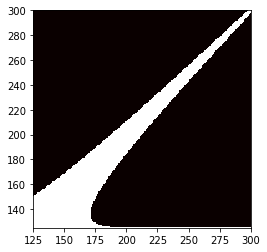

In [16]:
plt.imshow(viable_nd_ndp1, cmap='hot', interpolation='nearest')
plt.xlim(N_min_people, N_max_people)
plt.ylim(N_min_people, N_max_people)

In [17]:
# Possible choice for the family
# last choice is any day that is not on the family's preferred days
N_choices_ori = family_id_choice_to_pref_cost.shape[1]
N_choices = min(N_choices_ori, max_family_rank)
print('Limit family choice rank:', N_choices_ori, '->', N_choices)

Limit family choice rank: 11 -> 7


In [18]:
family_id_choice_to_pref_cost[:, :N_choices]

array([[  0,  50,  86, ..., 236, 272, 372],
       [  0,  50,  86, ..., 236, 272, 372],
       [  0,  50,  77, ..., 227, 254, 354],
       ...,
       [  0,  50, 104, ..., 254, 308, 408],
       [  0,  50,  95, ..., 245, 290, 390],
       [  0,  50,  86, ..., 236, 272, 372]])

## DOCplex model

In [19]:
from docplex.mp.model import Model

In [20]:
solver = Model('')

In [21]:
if num_cpu_cores > 0:
    solver.context.cplex_parameters.threads = num_cpu_cores
    print('Set num threads:', num_cpu_cores)
print('Num treads:', solver.context.cplex_parameters.threads)
if time_limit > 0:
    print('Set time limit:', solver.set_time_limit(time_limit))

Set num threads: 6
Num treads: threads:int(6)
Set time limit: None


In [22]:
solver.parameters.mip.tolerances.mipgap = 0  # set mip gap to 0

## Variables

In [23]:
# Variables
# assignment matrix[family, pref_rank]
assignment_matrix = solver.binary_var_matrix(families, range(N_choices), 'x')

In [24]:
len(assignment_matrix)

35000

In [25]:
possible_family_sizes = np.unique(n_people)

In [26]:
# unpreferred_day_counts[day, size]
if N_choices_ori <= N_choices:
    print('using unpreferred day counts')
    ub = int(N_max_people / possible_family_sizes.min())
    unpreferred_day_counts = solver.integer_var_matrix(days, possible_family_sizes, lb=0, ub=ub, name='d')
    print(len(unpreferred_day_counts))    

In [27]:
# Occupancy matrix [day, N_d, N_d+1]
occupancy_keys_list = []
for day in days:
    if day < N_days:
        for o in search_occupancy[day]:
            for o_next in search_occupancy[day + 1]:
                #if viable_nd_ndp1[o, o_next]:
                occupancy_keys_list.append((day, o, o_next))
    else:
        # last day
        for o in search_occupancy[day]:
            occupancy_keys_list.append((day, o))
occupancy_matrix = solver.binary_var_dict(occupancy_keys_list, name='o')

In [28]:
search_occupancy[N_days]

range(125, 176)

In [29]:
len(occupancy_matrix)

692065

## Constraints

### constraint 1: each family only take one day (choice)

In [30]:
# Constraints
# constraint 1: each family only take one day (choice)
solver.add_constraints_([
    solver.sum([assignment_matrix[family, c] for c in range(N_choices)]) == 1 
    for family in families
])

### constraint: choices limit

In [31]:
if min_choice_0_families > 0:
    solver.add_constraint_(
        solver.sum([assignment_matrix[family, 0] for family in families]) >= min_choice_0_families
    )

### occupancy counts

In [32]:
# constraint 2: each day can only have 125-300 people

In [33]:
N_family_pref = min(N_choices, N_choices_ori - 1)
N_family_pref

7

In [34]:
# day to dictionary of families who choose this day with value as preference rank
days_family_prefered = [{} for day in range(N_days+1)]  # day = 0 should not be used

In [35]:
for family, pref in enumerate(family_pref):
    for rank, day in enumerate(pref):
        if rank < N_family_pref:
            days_family_prefered[day][family] = rank

In [36]:
# occupancy count [intermediate variables]

if occupancy_count_as_variables:
    lbs = [min(search_occupancy[day]) for day in days]
    ubs = [max(search_occupancy[day]) for day in days]
    occupancy_counts = solver.integer_var_dict(days, lb=lbs, ub=ubs, name='oc')
    
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        solver.add_constraint_(
            occupancy_counts[day] == (
                solver.sum(
                    [assignment_matrix[family, pref_rank] * n_people[family] 
                     for family, pref_rank in family_prefered.items()]
                ) + (
                    solver.sum(
                        [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                    ) if N_choices >= N_choices_ori else 0
                )
            )
        )
else:
    occupancy_counts = {}
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        occupancy_counts[day] = (
            solver.sum(
                [assignment_matrix[family, pref_rank] * n_people[family] 
                 for family, pref_rank in family_prefered.items()]
            ) + (
                solver.sum(
                    [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                ) if N_choices >= N_choices_ori else 0
            )
        )

In [37]:
# for day in days:
#     # find those family who like this day
#     solver.Add(occupancy_counts[day] <= N_max_people, 'ub[%i]' % day)
#     solver.Add(occupancy_counts[day] >= N_min_people, 'ub[%i]' % day)

### constraint 3: unpreferred day family count conservation for each family size

In [38]:
# constraint 3: unpreferred day family count conservation for each family size

In [39]:
family_size_to_family_ids = {
    size: np.where(n_people == size)[0] for size in possible_family_sizes
}

In [40]:
if N_choices >= N_choices_ori:
    solver.add_constraints_([
        solver.sum([assignment_matrix[family, N_choices - 1]
                    for family in family_size_to_family_ids[size]])
        == solver.sum([unpreferred_day_counts[day, size] for day in days])
        for size in possible_family_sizes
    ])

### Occupancy boolean matrix normalization

In [41]:
# occupancy boolean matrix normalization
# each day only take 1 occupancy value
for day in days:
    if day < N_days:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o, o_next] 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
        ])
    else:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o] 
            for o in search_occupancy[day]
        ])
    solver.add_constraint_(occupancy_normalization == 1)

### constrain 4: link occupancy boolean matrix to occupancy count

In [42]:
for day in days:
    if day < N_days:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o, o_next] * o for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
        ])
    else:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o] * o for o in search_occupancy[day]
        ])
    solver.add_constraint_(occupancy_counts[day] == sum_from_occupancy_matrix)

In [43]:
# next day occupancy consistency
if True:
    # Approach 1: (faster)
    solver.add_constraints_([
        occupancy_counts[day + 1] == solver.sum([
            occupancy_matrix[day, o, o_next] * o_next for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
        ])
        for day in days if day < N_days
    ])
else:
    # Approach 2: (much slower)
    for day in days:
        if day + 1 < N_days:
            for o in search_occupancy[day+1]:
                solver.add_constraint_(
                    solver.sum(
                        [occupancy_matrix[day, o_other, o] for o_other in search_occupancy[day]]
                    ) == solver.sum(
                        [occupancy_matrix[day + 1, o, o_other] for o_other in search_occupancy[day+2]]
                    )
                )
    for o in search_occupancy[N_days]:
        solver.add_constraint_(
            solver.sum(
                [occupancy_matrix[N_days - 1, o_other, o] for o_other in search_occupancy[N_days - 1]]
            ) == occupancy_matrix[N_days, o]
        )

### Preference cost

In [44]:
family_pref_cost = solver.sum([
    assignment_matrix[family, c] * family_id_choice_to_pref_cost[family, c]
    for family in families for c in range(N_choices)
])

In [45]:
if target_pref_cost > 0:
    if target_pref_cost_error > 0:
        solver.add_constraints_([
            family_pref_cost <= target_pref_cost + target_pref_cost_error,
            family_pref_cost >= target_pref_cost - target_pref_cost_error
        ])
    else:
        solver.add_constraint_(family_pref_cost == target_pref_cost)

for i, (x, y) in enumerate(family_pref_cost.GetCoeffs().items()):
    if i >= 5: 
        break
    print(type(x), x, y)

family_pref_cost.GetCoeffs()[assignment_matrix[0, 1]]

### Accounting cost

In [46]:
accounting_cost = (
    solver.sum([
        occupancy_matrix[day, o, o_next] * nd_ndp1_to_account_penality[o, o_next]
        for day in days if day < N_days
        for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
    ]) +
    solver.sum([
        occupancy_matrix[N_days, o] * nd_ndp1_to_account_penality[o, o]
        for o in search_occupancy[N_days]
    ])
)

In [47]:
if target_accounting_cost > 0:
    solver.add_constraints_([
        accounting_cost <= target_accounting_cost + target_accounting_cost_error,
        accounting_cost >= target_accounting_cost - target_accounting_cost_error
    ])

In [48]:
#accounting_cost.GetCoeffs()[occupancy_matrix[100, 128]]

## Objective

In [49]:
# Objective - Preference cost only as approximation
solver.minimize(family_pref_cost + accounting_cost)  # family_pref_cost + 

## Hint

In [50]:
if use_hint:
    print('Using hint!')

    from docplex.mp.solution import SolveSolution
    var_value_map = {}
    
    for family in families:
        for c in range(N_choices):
            var_value_map[assignment_matrix[family, c]] = float(
                assigned_day[family] == family_pref[family, c]
            )
    for day in days:
        if day < N_days:
            for o in search_occupancy[day]:
                for o_next in search_occupancy[day + 1]:
                    var_value_map[occupancy_matrix[day, o, o_next]] = float(
                        (occupancy[day] == o) and (occupancy[day + 1] == o_next)
                    )
    for o in search_occupancy[N_days]:
        var_value_map[occupancy_matrix[N_days, o]] = float(occupancy[N_days] == o)

    if occupancy_count_as_variables:
        for day in days:
            var_value_map[occupancy_counts[day]] = float(occupancy[day])
    
    init_solution = SolveSolution(solver, var_value_map)
    solver.add_mip_start(init_solution)
    
#     solver.SetHint(
#         [assignment_matrix[family, c] for family in families for c in range(N_choices)] +
#         [
#             occupancy_matrix[day, o, o_next] 
#             for day in days if day < N_days
#             for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
#         ] +
#         [
#             occupancy_matrix[N_days, o] for o in search_occupancy[N_days]
#         ] +
#         [
#             occupancy_counts[day] for day in days
#         ] if occupancy_count_as_variables else []
#         ,
#         [
#             float(assigned_day[family] == family_pref[family, c]) 
#             for family in families for c in range(N_choices)
#         ] +
#         [
#             float((occupancy[day] == o) and (occupancy[day + 1] == o_next))
#             for day in days if day < N_days
#             for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
#         ] +
#         [
#             float(occupancy[N_days] == o) for o in search_occupancy[N_days]
#         ] +
#         [
#             float(occupancy[day]) for day in days
#         ] if occupancy_count_as_variables else []
#     )

Using hint!


## Solve

In [51]:
from docplex.mp.progress import TextProgressListener
from docplex.mp.progress import ProgressClock

In [52]:
solver.add_progress_listener(TextProgressListener(clock=ProgressClock.Gap))  # clock=ProgressClock.Objective, absdiff=10

In [53]:
solver.get_time_limit()

120.0

In [54]:
print('N of variables (binary, int):', solver.number_of_variables, 
      '(', solver.number_of_binary_variables, ',', solver.number_of_integer_variables, ')')
print('N of constraints:', solver.number_of_constraints)

N of variables (binary, int): 727165 ( 727065 , 100 )
N of constraints: 5400


In [55]:
%%time
# Solve
sol = solver.solve()

print('Solution status:', solver.get_solve_status())
print('Total cost:', sol.objective_value, sol.get_objective_value())
print("Time:", '%.3f' % solver.get_solve_details().time, "s")

  1+: Node=0 Left=1 Best Integer=70901.1684, Best Bound=69733.6269, gap=1.65%, ItCnt=8399 [20.1s]
  2+: Node=0 Left=1 Best Integer=70901.1684, Best Bound=70184.1348, gap=1.01%, ItCnt=9485 [50.1s]
  3+: Node=0 Left=1 Best Integer=70901.1684, Best Bound=70242.8516, gap=0.93%, ItCnt=11309 [88.5s]
  4+: Node=0 Left=1 Best Integer=70901.1684, Best Bound=70254.3656, gap=0.91%, ItCnt=11395 [120.7s]
Solution status: JobSolveStatus.FEASIBLE_SOLUTION
Total cost: 70901.16843914893 70901.16843914893
Time: 122.524 s
CPU times: user 4min 36s, sys: 8.32 s, total: 4min 44s
Wall time: 2min 3s


## Solution

In [56]:
assigned_day_new_raw = np.ones(assigned_day.shape, dtype='int32') * -1
for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
    assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1

In [57]:
assigned_day_new_raw

array([ 52,  26, 100, ...,  32,  92,  13], dtype=int32)

In [58]:
if N_choices >= N_choices_ori:
    unpreferred_day_counts_sol_dict = sol.get_value_dict(unpreferred_day_counts)
    unpreferred_day_counts_sol = {
        size: [0]+[int(unpreferred_day_counts_sol_dict[day, size]) for day in days]
        for size in possible_family_sizes
    }

    print('Unpreferred families slots:')
    {size: sum(counts) for size, counts in unpreferred_day_counts_sol.items()}

In [59]:
def distribute_unpreferred_day(assigned_day, unpreferred_day_counts_sol, n_people):
    """ Distribute unpreferred day to each family who has -1 day assigned """
    assigned_day = assigned_day.copy()
    unpreferred_days = {size: [] for size in possible_family_sizes}
    for size in possible_family_sizes:
        for day, quota in enumerate(unpreferred_day_counts_sol[size]):
            unpreferred_days[size] = unpreferred_days[size] + [day] * quota
    unpreferred_day_headers = {size: 0 for size in possible_family_sizes}
    for family, (day, size) in enumerate(zip(assigned_day, n_people)):
        if day == -1:
            assigned_day[family] = unpreferred_days[size][unpreferred_day_headers[size]]
            unpreferred_day_headers[size] += 1
    return assigned_day

In [60]:
if N_choices >= N_choices_ori:
    assigned_day_new = distribute_unpreferred_day(assigned_day_new_raw, unpreferred_day_counts_sol, n_people)
else:
    assigned_day_new = assigned_day_new_raw

In [61]:
print('N family unpreferred assigned:', (~(assigned_day_new == assigned_day_new_raw)).sum())

N family unpreferred assigned: 0


In [62]:
family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)
occupancy_new = assigned_day_to_occupancy(assigned_day_new)

In [63]:
try:
    is_valid = deep_check(assigned_day_new, family_on_day_new, occupancy_new)
except:
    is_valid = False
new_score = cal_total(assigned_day_new, occupancy_new)
print('Valid solution: ', is_valid)
print('Total score:    ', new_score, '(', new_score - initial_score, ')')
print('Preference cost:', cal_total_preference(assigned_day_new))
print('Accounting cost:', cal_total_accounting(occupancy_new))

deep check: everything looks fine.
Valid solution:  True
Total score:     70901.16843914894 ( 0.0 )
Preference cost: 65596
Accounting cost: 5305.168439148937


## Output

In [64]:
is_improved = new_score < initial_score
if is_valid and (is_improved or (path_dump_improved != path_init_conf)):
    print('output to', path_dump_improved)
    dump_conf(assigned_day_new, path_dump_improved)

## Debug

In [65]:
# [
#     [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
#     for family in range(10)
# ]        

In [66]:
# if N_choices >= N_choices_ori:
#     print([
#         [unpreferred_day_counts[day, size].solution_value() for size in possible_family_sizes]
#         for day in range(1, 10)
#     ])